In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

In [2]:
paths = ['MF_D/','MF_MS/','MS_D/','MF_D_Full/','MF_MS_Full/','MS_D_Full/']

In [25]:
def fw2(x):
    d = x.shape
    m = np.max(x)
    for i in range(d[0]):
        for j in range(d[1]):
            if x[i, j] == m:
                return [i, j]
            
def plot_nav(return_lst):
    nav = 1
    nav_lst = [1]
    for ret in return_lst:
        nav = nav * (1+ ret*0.01)
        nav_lst.append(nav)
    plt.plot(range(len(return_lst)+1),nav_lst)
    plt.show()

# Loading Data

In [4]:
df = pd.concat(pd.read_csv('Data/Russell.csv', chunksize = 10000))
ts = pd.read_csv('Data/tspredictors_1950.csv')
# Downcast to lower memory usage
df = df.apply(pd.to_numeric, downcast = 'float')
df = df.apply(pd.to_numeric, downcast = 'unsigned')
ts = ts.apply(pd.to_numeric, downcast = 'float')

df['year'] = df['date'].astype(str).str[0:4].astype('uint16')
df['month'] = df['date'].astype(str).str[4:6].astype('uint32')
df['year_month'] = df['date'].astype(str).str[0:6].astype('uint32')
years = np.arange(1957, 2017)

macro = df.merge(ts, how = 'left', left_on = 'year_month', right_on = 'date', suffixes = ('_x', '')).iloc[:, 102:]
macro['C'] = 1
cols = ['C', 'dp', 'ep', 'bm', 'ntis', 'tbl', 'tms', 'dfy', 'svar'] #constant + 8 aggregate ts variable
macro = macro[cols]

y = df['ret']

C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\tools\numeric.py:148: RuntimeWarning: invalid value encountered in greater_equal
  elif downcast == 'unsigned' and np.min(values) >= 0:


# Load Model and Model Prediction with Partial Feature Set

In [33]:
from scipy.stats import spearmanr, pearsonr
paths = ['XGBoost/SR_CR/','RF/MF_D/','RF/MF_MS/', 'RF/MS_D/']
for path in paths:
    results = []
    params = []
    monthly_returns = []
    monthly_returns_decile = []
    monthly_r2oos = []
    for year in range(1982,2014):
        model_path = 'Models/'+path+str(year)+'.sav'
        print(model_path)
        model = pickle.load(open(model_path,'rb'))
        oos_sample = df[df['year'].isin([year])]
        #print(oos_sample)
        #print(oos_sample.shape)
        #print(list(oos_sample.columns.unique()))
        oos_idx = oos_sample.index
        monthly_idxs = []
        for i in range(1,13):
            monthly_idxs.append(oos_sample.index[oos_sample['month'] == i])
        x_oos = df.iloc[oos_idx, 0:94]*macro.iloc[oos_idx, 0][:, np.newaxis]
        x_oos = pd.concat((x_oos, pd.get_dummies(df['sic2'].astype(str), prefix = 'sic2').iloc[oos_idx, :-1]), axis = 1)
        
        y_oos = y[oos_idx]
        for i in range(12):
            tmp = pd.DataFrame()
            y_hat = model.predict(x_oos[x_oos.index.isin(monthly_idxs[i])])
            tmp['predicted'] = list(y_hat)
            tmp['actual'] = list(y_oos[y_oos.index.isin(monthly_idxs[i])])

            sorted_return = tmp.sort_values('predicted')
            chunksize = int(len(sorted_return)/10)
            long = sorted_return[-chunksize:]
            short = sorted_return[:-chunksize]
            last_decile = sorted_return[:chunksize]

            ret = (long['actual'].mean()-short['actual'].mean()) * 100
            decile_ret = (long['actual'].mean() - last_decile['actual'].mean())* 100
            r2_oos = 1 - sum(np.power(y_hat - y_oos[y_oos.index.isin(monthly_idxs[i])], 2))/sum(np.power(y_oos[y_oos.index.isin(monthly_idxs[i])] ,2))
            s = spearmanr(tmp['predicted'],tmp['actual']).correlation
            p = pearsonr(tmp['predicted'], tmp['actual'])[0]
            corr = {'spearman':s,'pearson':p, 'ret':ret, 'decile_ret':decile_ret,'r2_oos':r2_oos}
            results.append(corr)
    print(len(results))
    pd.DataFrame(results).to_csv('Results/'+path+'modelstats.csv')


Models/XGBoost/SR_CR/1982.sav
Models/XGBoost/SR_CR/1983.sav
Models/XGBoost/SR_CR/1984.sav
Models/XGBoost/SR_CR/1985.sav
Models/XGBoost/SR_CR/1986.sav
Models/XGBoost/SR_CR/1987.sav
Models/XGBoost/SR_CR/1988.sav
Models/XGBoost/SR_CR/1989.sav
Models/XGBoost/SR_CR/1990.sav
Models/XGBoost/SR_CR/1991.sav
Models/XGBoost/SR_CR/1992.sav
Models/XGBoost/SR_CR/1993.sav
Models/XGBoost/SR_CR/1994.sav
Models/XGBoost/SR_CR/1995.sav
Models/XGBoost/SR_CR/1996.sav
Models/XGBoost/SR_CR/1997.sav
Models/XGBoost/SR_CR/1998.sav
Models/XGBoost/SR_CR/1999.sav
Models/XGBoost/SR_CR/2000.sav
Models/XGBoost/SR_CR/2001.sav
Models/XGBoost/SR_CR/2002.sav
Models/XGBoost/SR_CR/2003.sav
Models/XGBoost/SR_CR/2004.sav
Models/XGBoost/SR_CR/2005.sav
Models/XGBoost/SR_CR/2006.sav
Models/XGBoost/SR_CR/2007.sav
Models/XGBoost/SR_CR/2008.sav
Models/XGBoost/SR_CR/2009.sav
Models/XGBoost/SR_CR/2010.sav
Models/XGBoost/SR_CR/2011.sav
Models/XGBoost/SR_CR/2012.sav
Models/XGBoost/SR_CR/2013.sav
384
Models/RF/MF_D/1982.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1983.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1984.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1985.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1986.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1987.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1988.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1989.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1990.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1991.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1992.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1993.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1994.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1995.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1996.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1997.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1998.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/1999.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2000.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2001.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2002.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2003.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2004.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2005.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2006.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2007.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2008.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2009.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2010.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2011.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2012.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D/2013.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


384
Models/RF/MF_MS/1982.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1983.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1984.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1985.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1986.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1987.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1988.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1989.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1990.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1991.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1992.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1993.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1994.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1995.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1996.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1997.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1998.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/1999.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2000.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2001.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2002.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2003.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2004.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2005.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2006.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2007.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2008.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2009.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2010.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2011.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2012.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS/2013.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


384
Models/RF/MS_D/1982.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1983.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1984.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1985.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1986.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1987.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1988.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1989.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1990.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1991.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1992.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1993.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1994.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1995.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1996.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1997.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1998.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/1999.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2000.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2001.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2002.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2003.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2004.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2005.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2006.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2007.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2008.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2009.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2010.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2011.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2012.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D/2013.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


384


# Load Model and Model Prediction with Full Set Features

In [22]:
paths = ['RF/MF_D_Full/','RF/MF_MS_Full/','RF/MS_D_Full/']
for path in paths:
    results = []
    for year in range(1982,2014):
        model_path = 'Models/'+path+str(year)+'.sav'
        print(model_path)
        model = pickle.load(open(model_path,'rb'))
        oos_sample = df[df['year'].isin([year])]
        #print(oos_sample.shape)
        #print(list(oos_sample.columns.unique()))
        oos_idx = oos_sample.index
        monthly_idxs = []
        for i in range(1,13):
            monthly_idxs.append(oos_sample.index[oos_sample['month'] == i])
            
        x_oos = df.iloc[oos_idx, 0:94]*macro.iloc[oos_idx, 0][:, np.newaxis]
        for i in range(1, macro.shape[1]):
            x_oos = pd.concat((x_oos, df.iloc[oos_idx, 0:94]*macro.iloc[oos_idx, i][:, np.newaxis]), axis = 1)
        
        x_oos.columns = [a + '*' + b for b in macro.columns for a in df.columns[0:94]]    
        x_oos = pd.concat((x_oos, pd.get_dummies(df['sic2'].astype(str), prefix = 'sic2').iloc[oos_idx, :-1]), axis = 1)
        y_oos = y[oos_idx]
        
        for i in range(12):
            tmp = pd.DataFrame()
            y_hat = model.predict(x_oos[x_oos.index.isin(monthly_idxs[i])])
            tmp['predicted'] = list(y_hat)
            tmp['actual'] = list(y_oos[y_oos.index.isin(monthly_idxs[i])])

            sorted_return = tmp.sort_values('predicted')
            chunksize = int(len(sorted_return)/10)
            long = sorted_return[-chunksize:]
            short = sorted_return[:-chunksize]
            last_decile = sorted_return[:chunksize]

            ret = (long['actual'].mean()-short['actual'].mean()) * 100
            decile_ret = (long['actual'].mean() - last_decile['actual'].mean())* 100
            r2_oos = 1 - sum(np.power(y_hat - y_oos[y_oos.index.isin(monthly_idxs[i])], 2))/sum(np.power(y_oos[y_oos.index.isin(monthly_idxs[i])] ,2))
            s = spearmanr(tmp['predicted'],tmp['actual']).correlation
            p = pearsonr(tmp['predicted'], tmp['actual'])[0]
            corr = {'spearman':s,'pearson':p, 'ret':ret, 'decile_ret':decile_ret,'r2_oos':r2_oos}
            results.append(corr)
    pd.DataFrame(results).to_csv('Results/'+path+'modelstats.csv')

Models/RF/MF_D_Full/1982.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1983.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1984.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1985.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1986.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1987.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1988.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1989.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1990.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1991.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1992.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1993.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1994.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1995.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1996.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1997.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1998.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/1999.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2000.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2001.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2002.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2003.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2004.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2005.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2006.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2007.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2008.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2009.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-pack

Models/RF/MF_D_Full/2010.sav
Models/RF/MF_D_Full/2011.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2012.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_D_Full/2013.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1982.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1983.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1984.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1985.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1986.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1987.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1988.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1989.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1990.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1991.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1992.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1993.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1994.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1995.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1996.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1997.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1998.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/1999.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-pack

Models/RF/MF_MS_Full/2000.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-pack

Models/RF/MF_MS_Full/2001.sav
Models/RF/MF_MS_Full/2002.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2003.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2004.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2005.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2006.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2007.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2008.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2009.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2010.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2011.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2012.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MF_MS_Full/2013.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1982.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1983.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1984.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1985.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1986.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1987.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1988.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1989.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1990.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1991.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1992.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1993.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1994.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1995.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1996.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1997.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1998.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/1999.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2000.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2001.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2002.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2003.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2004.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2005.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2006.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2007.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2008.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2009.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2010.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2011.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2012.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Models/RF/MS_D_Full/2013.sav


C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zheji\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Analyzing each model's performance 

384
Performance for model  RF/MF_D
       decile_ret     pearson      r2_oos         ret    spearman
count  384.000000  384.000000  384.000000  384.000000  384.000000
mean     1.859720    0.024845    0.008467    1.317365    0.019809
std      4.565171    0.091975    0.085815    3.267918    0.113610
min    -11.491073   -0.251263   -0.262449   -7.035712   -0.306063
25%     -0.956667   -0.029368   -0.049411   -0.813504   -0.058204
50%      1.571236    0.020104    0.024363    1.088883    0.029394
75%      4.272269    0.078771    0.071257    3.004300    0.094293
max     25.509707    0.366670    0.179148   18.309956    0.356521
            decile_ret   pearson    r2_oos       ret  spearman
decile_ret    1.000000  0.697111  0.438211  0.858083  0.797006
pearson       0.697111  1.000000  0.489242  0.702318  0.633859
r2_oos        0.438211  0.489242  1.000000  0.403586  0.483661
ret           0.858083  0.702318  0.403586  1.000000  0.602997
spearman      0.797006  0.633859  0.483661  0.602997  1.

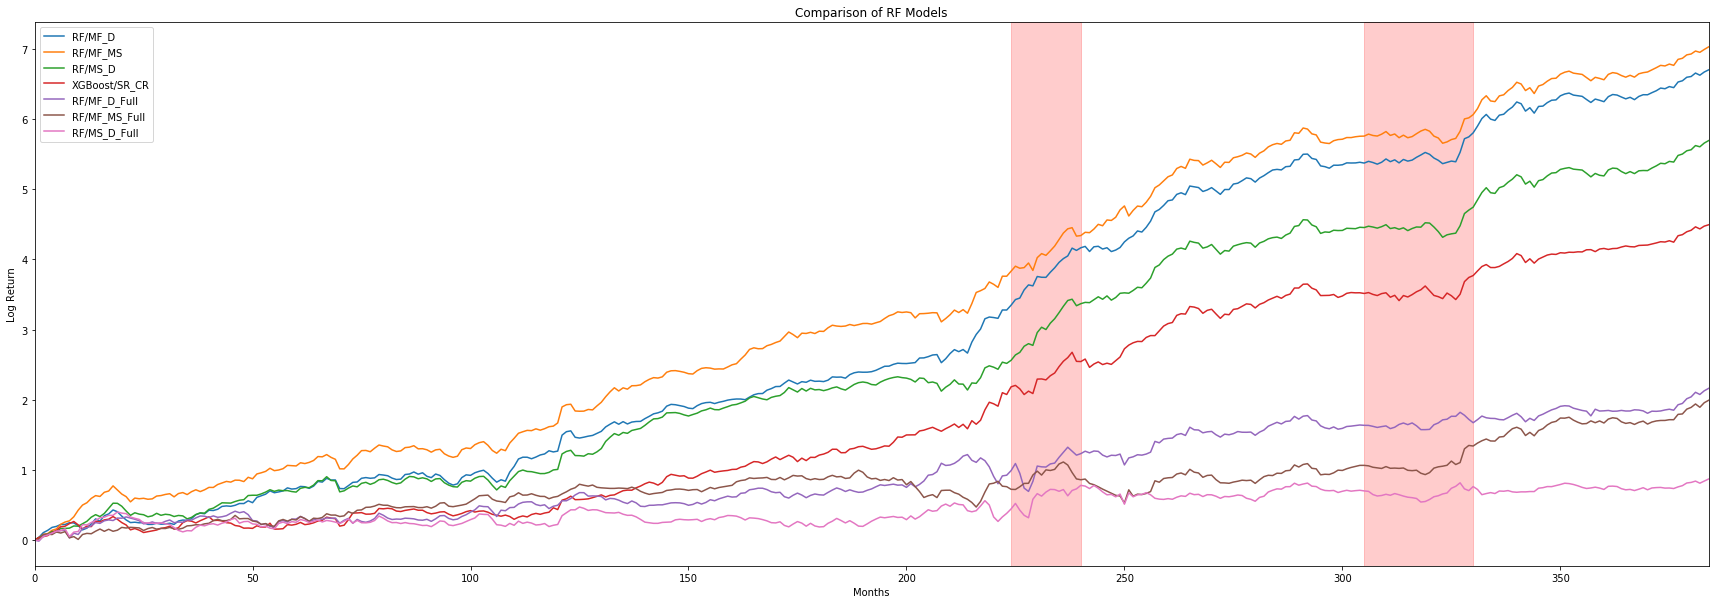

In [40]:
navs = {}
summary = pd.DataFrame()
paths = ['RF/MF_D/','RF/MF_MS/','RF/MS_D/','XGBoost/SR_CR/','RF/MF_D_Full/','RF/MF_MS_Full/','RF/MS_D_Full/']
for path in paths:
    navs[path[:-1]] = [0]
    nav = 1
    stats = pd.read_csv('Results/'+path+'modelstats.csv')
    print(len(stats))
    del stats['Unnamed: 0']
    print("Performance for model ",path[:-1])
    print(stats.describe())
    print(stats.corr())
    for ret in stats['decile_ret'].values:
        nav = nav * (1+ret*0.01)
        navs[path[:-1]].append(np.log(nav))
    print('-'*50)
    
rets = pd.DataFrame(navs)
rets.plot(figsize=(30,10))
plt.axvspan(224,240, color='red',alpha=0.2)
plt.axvspan(305,330, color='red',alpha=0.2)
plt.xlabel('Months')
plt.ylabel('Log Return')
plt.title("Comparison of RF Models")
plt.show()

# Code below need modifications and improvements

# Analyzing Overfitting in Hyperparameter Tuning

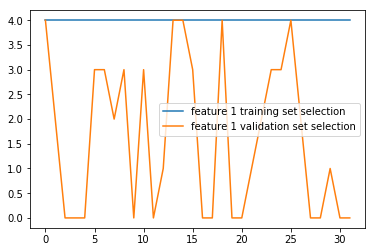

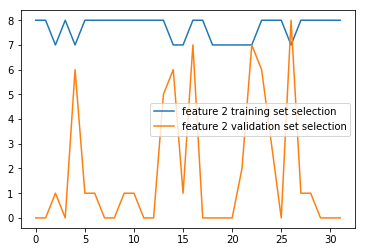

--------------------------------------------------


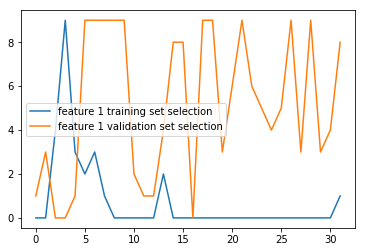

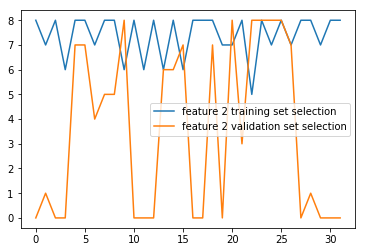

--------------------------------------------------


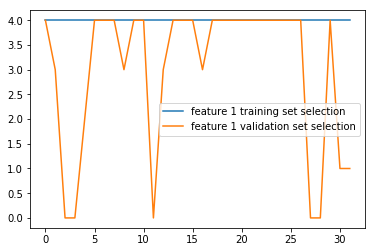

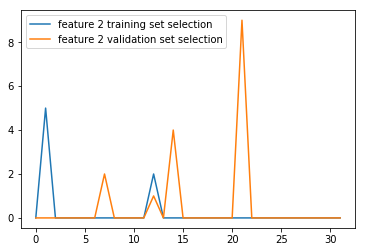

--------------------------------------------------


In [43]:
specs = {'XGBoost/LR_D':{'Learning Rate':[-1,-0.8,-0.6,-0.4,-0.2,0], 'Depth': range(1,6,1)},
         'XGBoost/Alpha_Lambda':{''}} #haven't finished code
paths = ['XGBoost/LR_D/','XGBoost/Alpha_Lambda']
paths = ['RF/MF_D/','RF/MF_MS/','RF/MS_D/']
specs = {'RF/MF_D/':{'Depth':range(1,6,1),'Max_Features':range(20,65,5)},
         'RF/MF_MS/':{"Min_Samples":range(1,11,1),'Max_Features':range(20,65,5)},
         'RF/MS_D/':{'Depth':range(1,6,1),'Min_Samples':range(1,11,1)}}
for path in paths:
    train_f1 = []
    train_f2 = []
    val_f1 = []
    val_f2 = []
    for year in range(1982,2014):
        train_r2 = pd.read_csv('Results/'+path+'r2_train'+str(year)+'.csv')
        val_r2 = pd.read_csv('Results/'+path+'r2_oos'+str(year)+'.csv')
        del train_r2['Unnamed: 0']
        del val_r2['Unnamed: 0']
#         train_row = train_r2.sum(axis=0)/train_r2.shape[0]
#         train_column = train_r2.sum(axis=1)/train_r2.shape[1]
#         val_row = val_r2.sum(axis=0)/val_r2.shape[0]
#         val_column = val_r2.sum(axis=1)/val_r2.shape[1]
#         plt.plot(train_row,label='train_r2')
#         plt.plot(val_row, label='val_r2')
#         plt.legend()
#         plt.show()

#         plt.plot(train_column,label='train_r2')
#         plt.plot(val_column, label='val_r2')
#         plt.legend()
#         plt.show()
#         print('-'*100)
#         #print(fw2(train_r2))
        train_r2 = train_r2.values
        val_r2 = val_r2.values


        train_f1.append(fw2(train_r2)[0])
        train_f2.append(fw2(train_r2)[1])
        val_f1.append(fw2(val_r2)[0])
        val_f2.append(fw2(val_r2)[1])
    plt.plot(train_f1, label='feature 1 training set selection')
    plt.plot(val_f1, label='feature 1 validation set selection')
    plt.legend()
    plt.show()

    plt.plot(train_f2, label='feature 2 training set selection')
    plt.plot(val_f2, label='feature 2 validation set selection')
    plt.legend()
    plt.show()
    print('-'*50)


# Analyze Model Hyperparameter Selection

In [66]:
path = 'XGBoost/LR_D/'
params = []
for year in range(1982,2015):
    model = pickle.load(open('Models/'+path+str(year)+'.sav','rb'))
    params.append(model.get_params())
params = pd.DataFrame(params)
params.describe()  
# LR mean 0.46, 50% 0.39 --> 0.4 is probably where we want to set
# Depth mean 1.6 50% 1 --> 1 is probably where we want to set

,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,missing,n_estimators,n_jobs,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample,verbosity
count,33.000000,33.0,33.0,33.0,33.0,33.000000,33.0,33.000000,33.0,0.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0,33.0
mean,0.013478,1.0,1.0,1.0,0.0,0.460710,0.0,1.606061,1.0,NaN,100.0,-1.0,7.0,0.0,0.0,1.0,1.0,1.0
std,0.002894,0.0,0.0,0.0,0.0,0.339110,0.0,0.899284,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.004774,1.0,1.0,1.0,0.0,0.100000,0.0,1.000000,1.0,NaN,100.0,-1.0,7.0,0.0,0.0,1.0,1.0,1.0
25%,0.011733,1.0,1.0,1.0,0.0,0.158489,0.0,1.000000,1.0,NaN,100.0,-1.0,7.0,0.0,0.0,1.0,1.0,1.0
50%,0.014043,1.0,1.0,1.0,0.0,0.398107,0.0,1.000000,1.0,NaN,100.0,-1.0,7.0,0.0,0.0,1.0,1.0,1.0
75%,0.015584,1.0,1.0,1.0,0.0,0.630957,0.0,2.000000,1.0,NaN,100.0,-1.0,7.0,0.0,0.0,1.0,1.0,1.0
max,0.017059,1.0,1.0,1.0,0.0,1.000000,0.0,5.000000,1.0,NaN,100.0,-1.0,7.0,0.0,0.0,1.0,1.0,1.0


In [58]:
path = 'XGBoost/Alpha_Lambda/'
params = []
for year in range(1982,2015):
    model = pickle.load(open('Models/'+path+str(year)+'.sav','rb'))
    params.append(model.get_params())
params = pd.DataFrame(params)
params.describe()  
# alpha mean 0.31, 50% 0.45 --> 0.4 is probably where we want to set
# lambda mean 0.36 50% 0.45 --> 0.4 is probably where we want to set


,base_score,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_delta_step,max_depth,min_child_weight,missing,n_estimators,n_jobs,random_state,reg_alpha,reg_lambda,scale_pos_weight,subsample,verbosity
count,33.000000,33.0,33.0,33.0,33.0,3.300000e+01,33.0,33.0,33.0,0.0,33.0,33.0,33.0,33.000000,33.000000,33.0,33.0,33.0
mean,0.013478,1.0,1.0,1.0,0.0,2.000000e-01,0.0,3.0,1.0,NaN,100.0,-1.0,7.0,0.319697,0.360606,1.0,1.0,1.0
std,0.002894,0.0,0.0,0.0,0.0,8.455776e-17,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.184958,0.162864,0.0,0.0,0.0
min,0.004774,1.0,1.0,1.0,0.0,2.000000e-01,0.0,3.0,1.0,NaN,100.0,-1.0,7.0,0.000000,0.000000,1.0,1.0,1.0
25%,0.011733,1.0,1.0,1.0,0.0,2.000000e-01,0.0,3.0,1.0,NaN,100.0,-1.0,7.0,0.250000,0.400000,1.0,1.0,1.0
50%,0.014043,1.0,1.0,1.0,0.0,2.000000e-01,0.0,3.0,1.0,NaN,100.0,-1.0,7.0,0.450000,0.450000,1.0,1.0,1.0
75%,0.015584,1.0,1.0,1.0,0.0,2.000000e-01,0.0,3.0,1.0,NaN,100.0,-1.0,7.0,0.450000,0.450000,1.0,1.0,1.0
max,0.017059,1.0,1.0,1.0,0.0,2.000000e-01,0.0,3.0,1.0,NaN,100.0,-1.0,7.0,0.450000,0.450000,1.0,1.0,1.0
